<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/k_fold_cross_validation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
import numpy as np
import os
import timm
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision import transforms
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import shutil
import glob

# Configuration
batch_size = 96
epochs = 70
lr = 0.1 * 3e-4
gamma = 0.8
seed = 42
k_folds = 5

# Set random seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/image_RA'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/image_nonRA'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

In [18]:


device = 'cuda'

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=8),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.08)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    transforms.RandomPerspective(distortion_scale=0.12, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data directory
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

# Custom dataset
class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color='gray')
            img = self.transform(img)
            target = 0
            return img, target

# Full dataset for k-fold
full_dataset = RobustImageFolder(train_dir, transform=train_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

# Targets for k-fold split
targets = [sample[1] for sample in full_dataset.samples]
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

# Metrics storage
fold_metrics = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'test_loss': [], 'test_acc': []
}

class Mixup:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

# Training and evaluation for one fold
def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=0.2)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            # Mixup accuracy calculation
            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                   (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # Validation phase
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

        torch.cuda.empty_cache()

        # Log metrics
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)

        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}"
        )

        scheduler.step()

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list

def evaluate_on_test(model, test_loader, criterion, device):
    """
    Evaluate the model on the test set.

    Parameters:
        model: Trained model to evaluate.
        test_loader: DataLoader for the test set.
        criterion: Loss function.
        device: Device to perform computation on (CPU or GPU).

    Returns:
        test_loss: Average loss on the test set.
        test_accuracy: Accuracy on the test set.
    """
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            accuracy = (outputs.argmax(dim=1) == labels).float().mean().item()
            test_accuracy += accuracy

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    return test_loss, test_accuracy


# Main k-fold loop
def main_kfold():
    for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset.samples, targets)):
        print(f"\n=== Fold {fold+1}/{k_folds} ===")

        # Create data subsets
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2
        )
        val_loader = DataLoader(
            val_subset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True,
            persistent_workers=True
        )

        # Initialize model
        model = timm.create_model(
            'swin_base_patch4_window7_224.ms_in1k',
            pretrained=True,
            num_classes=2,
            drop_block_rate=None,
            drop_connect_rate=None,
            drop_rate=0.45,
            attn_drop_rate=0.35,
            drop_path_rate=0.35
        ).to(device)

        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=6e-3)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2, eta_min=1e-7)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Train and validate
        train_acc, val_acc, train_loss, val_loss = train_with_gradient_accumulation(
            model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, epochs
        )

        # Test evaluation
        test_loss, test_acc = evaluate_on_test(model, test_loader, criterion, device)
        print(f"Fold {fold+1}: Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")


        fold_metrics['train_loss'].append(train_loss)
        fold_metrics['train_acc'].append(train_acc)
        fold_metrics['val_loss'].append(val_loss)
        fold_metrics['val_acc'].append(val_acc)

    # Aggregate results
    print("\n=== Final K-Fold Results ===")
    for key, values in fold_metrics.items():
        # Convert all elements in `values` to CPU numpy arrays
        converted_values = []
        for v in values:
            if isinstance(v, torch.Tensor):
                converted_values.append(v.detach().cpu().numpy())  # Use detach() to avoid tracking gradients
            elif isinstance(v, list):
                converted_values.append(np.array([x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in v]))
            else:
                converted_values.append(np.array(v))  # Convert to numpy if it's not already

        values = [np.mean(cv) for cv in converted_values]  # Compute mean for each fold
        print(f"{key}: mean={np.mean(values):.4f}, std={np.std(values):.4f}")

main_kfold()



=== Fold 1/5 ===


<ipython-input-18-9e0eaadf897c>:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-18-9e0eaadf897c>:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/70 - Train Loss: 0.7142, Train Acc: 0.4889, Val Loss: 0.6804, Val Acc: 0.5455


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/70 - Train Loss: 0.6797, Train Acc: 0.5784, Val Loss: 0.6870, Val Acc: 0.5682


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/70 - Train Loss: 0.6869, Train Acc: 0.5278, Val Loss: 0.6934, Val Acc: 0.5682


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/70 - Train Loss: 0.6849, Train Acc: 0.5681, Val Loss: 0.6978, Val Acc: 0.5455


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/70 - Train Loss: 0.6616, Train Acc: 0.6138, Val Loss: 0.7176, Val Acc: 0.5682


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/70 - Train Loss: 0.6425, Train Acc: 0.6148, Val Loss: 0.7013, Val Acc: 0.5455


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/70 - Train Loss: 0.6042, Train Acc: 0.7214, Val Loss: 0.6946, Val Acc: 0.5227


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/70 - Train Loss: 0.6070, Train Acc: 0.7198, Val Loss: 0.6215, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/70 - Train Loss: 0.6068, Train Acc: 0.6857, Val Loss: 0.6759, Val Acc: 0.6364


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/70 - Train Loss: 0.6301, Train Acc: 0.6610, Val Loss: 0.6663, Val Acc: 0.6364


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/70 - Train Loss: 0.5974, Train Acc: 0.7046, Val Loss: 0.6261, Val Acc: 0.6818


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/70 - Train Loss: 0.6032, Train Acc: 0.6998, Val Loss: 0.6693, Val Acc: 0.6136


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/70 - Train Loss: 0.6423, Train Acc: 0.7039, Val Loss: 0.6256, Val Acc: 0.6818


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/70 - Train Loss: 0.6431, Train Acc: 0.6549, Val Loss: 0.6513, Val Acc: 0.6818


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/70 - Train Loss: 0.5935, Train Acc: 0.6892, Val Loss: 0.6587, Val Acc: 0.6136


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/70 - Train Loss: 0.5738, Train Acc: 0.7319, Val Loss: 0.6483, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/70 - Train Loss: 0.5355, Train Acc: 0.7696, Val Loss: 0.6245, Val Acc: 0.6818


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/70 - Train Loss: 0.6011, Train Acc: 0.6794, Val Loss: 0.6588, Val Acc: 0.5455


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/70 - Train Loss: 0.6434, Train Acc: 0.6902, Val Loss: 0.6111, Val Acc: 0.7045


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/70 - Train Loss: 0.5912, Train Acc: 0.7056, Val Loss: 0.5905, Val Acc: 0.6364


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/70 - Train Loss: 0.6283, Train Acc: 0.6623, Val Loss: 0.6293, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/70 - Train Loss: 0.5931, Train Acc: 0.7032, Val Loss: 0.6219, Val Acc: 0.6818


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/70 - Train Loss: 0.5999, Train Acc: 0.7281, Val Loss: 0.6546, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/70 - Train Loss: 0.5272, Train Acc: 0.7562, Val Loss: 0.6257, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/70 - Train Loss: 0.5507, Train Acc: 0.7544, Val Loss: 0.6335, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/70 - Train Loss: 0.5436, Train Acc: 0.7467, Val Loss: 0.5818, Val Acc: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/70 - Train Loss: 0.5755, Train Acc: 0.7130, Val Loss: 0.6052, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/70 - Train Loss: 0.5527, Train Acc: 0.7544, Val Loss: 0.5931, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/70 - Train Loss: 0.5851, Train Acc: 0.7030, Val Loss: 0.6183, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/70 - Train Loss: 0.5790, Train Acc: 0.7442, Val Loss: 0.6243, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/70 - Train Loss: 0.5020, Train Acc: 0.7885, Val Loss: 0.6228, Val Acc: 0.6364


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/70 - Train Loss: 0.4806, Train Acc: 0.8308, Val Loss: 0.6077, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/70 - Train Loss: 0.5328, Train Acc: 0.7563, Val Loss: 0.6236, Val Acc: 0.7045


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/70 - Train Loss: 0.5386, Train Acc: 0.7321, Val Loss: 0.5788, Val Acc: 0.7045


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/70 - Train Loss: 0.5611, Train Acc: 0.7311, Val Loss: 0.6374, Val Acc: 0.6136


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/70 - Train Loss: 0.4966, Train Acc: 0.8183, Val Loss: 0.5487, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/70 - Train Loss: 0.5125, Train Acc: 0.7770, Val Loss: 0.5798, Val Acc: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/70 - Train Loss: 0.5816, Train Acc: 0.7448, Val Loss: 0.5529, Val Acc: 0.7727


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/70 - Train Loss: 0.5830, Train Acc: 0.7444, Val Loss: 0.5729, Val Acc: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/70 - Train Loss: 0.5169, Train Acc: 0.7980, Val Loss: 0.6216, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/70 - Train Loss: 0.4920, Train Acc: 0.8035, Val Loss: 0.5586, Val Acc: 0.8182


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/70 - Train Loss: 0.4678, Train Acc: 0.8312, Val Loss: 0.5650, Val Acc: 0.7727


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/70 - Train Loss: 0.4937, Train Acc: 0.8027, Val Loss: 0.5364, Val Acc: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/70 - Train Loss: 0.4820, Train Acc: 0.8091, Val Loss: 0.5878, Val Acc: 0.7045


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/70 - Train Loss: 0.5004, Train Acc: 0.7998, Val Loss: 0.5948, Val Acc: 0.7045


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/70 - Train Loss: 0.5253, Train Acc: 0.7828, Val Loss: 0.6247, Val Acc: 0.6818


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/70 - Train Loss: 0.6016, Train Acc: 0.7059, Val Loss: 0.5809, Val Acc: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/70 - Train Loss: 0.5154, Train Acc: 0.7626, Val Loss: 0.5496, Val Acc: 0.7727


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/70 - Train Loss: 0.4576, Train Acc: 0.8443, Val Loss: 0.5914, Val Acc: 0.6364


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/70 - Train Loss: 0.5125, Train Acc: 0.7722, Val Loss: 0.6031, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51/70 - Train Loss: 0.5090, Train Acc: 0.8164, Val Loss: 0.5211, Val Acc: 0.7727


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52/70 - Train Loss: 0.4524, Train Acc: 0.8244, Val Loss: 0.5544, Val Acc: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53/70 - Train Loss: 0.5560, Train Acc: 0.7708, Val Loss: 0.5491, Val Acc: 0.7045


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54/70 - Train Loss: 0.5451, Train Acc: 0.7443, Val Loss: 0.6145, Val Acc: 0.6136


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55/70 - Train Loss: 0.5443, Train Acc: 0.7553, Val Loss: 0.5402, Val Acc: 0.7727


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56/70 - Train Loss: 0.5293, Train Acc: 0.7714, Val Loss: 0.6019, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57/70 - Train Loss: 0.4489, Train Acc: 0.8136, Val Loss: 0.5997, Val Acc: 0.6591


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58/70 - Train Loss: 0.4324, Train Acc: 0.8332, Val Loss: 0.5313, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59/70 - Train Loss: 0.4560, Train Acc: 0.8416, Val Loss: 0.5483, Val Acc: 0.7727


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/70 - Train Loss: 0.5331, Train Acc: 0.7527, Val Loss: 0.5693, Val Acc: 0.7045


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61/70 - Train Loss: 0.4865, Train Acc: 0.8171, Val Loss: 0.5653, Val Acc: 0.7727


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62/70 - Train Loss: 0.4528, Train Acc: 0.8178, Val Loss: 0.5847, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63/70 - Train Loss: 0.6086, Train Acc: 0.7083, Val Loss: 0.5854, Val Acc: 0.7727


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64/70 - Train Loss: 0.6174, Train Acc: 0.6931, Val Loss: 0.5841, Val Acc: 0.6818


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65/70 - Train Loss: 0.6282, Train Acc: 0.6948, Val Loss: 0.5776, Val Acc: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66/70 - Train Loss: 0.5206, Train Acc: 0.7749, Val Loss: 0.5613, Val Acc: 0.7273


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67/70 - Train Loss: 0.4363, Train Acc: 0.8479, Val Loss: 0.5464, Val Acc: 0.7500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68/70 - Train Loss: 0.5243, Train Acc: 0.7808, Val Loss: 0.4958, Val Acc: 0.8409


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69/70 - Train Loss: 0.4904, Train Acc: 0.8088, Val Loss: 0.6181, Val Acc: 0.6136


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/70 - Train Loss: 0.4406, Train Acc: 0.8529, Val Loss: 0.5430, Val Acc: 0.8182
Fold 1: Test Loss = 0.5932, Test Accuracy = 0.6316

=== Fold 2/5 ===


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/70 - Train Loss: 0.6973, Train Acc: 0.5007, Val Loss: 0.7239, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/70 - Train Loss: 0.6773, Train Acc: 0.5549, Val Loss: 0.7232, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/70 - Train Loss: 0.6756, Train Acc: 0.5889, Val Loss: 0.7214, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/70 - Train Loss: 0.6969, Train Acc: 0.5382, Val Loss: 0.7119, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/70 - Train Loss: 0.6596, Train Acc: 0.6459, Val Loss: 0.7232, Val Acc: 0.5581


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/70 - Train Loss: 0.6669, Train Acc: 0.6061, Val Loss: 0.6871, Val Acc: 0.5581


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/70 - Train Loss: 0.6679, Train Acc: 0.5463, Val Loss: 0.7171, Val Acc: 0.4884


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/70 - Train Loss: 0.6251, Train Acc: 0.6679, Val Loss: 0.6435, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/70 - Train Loss: 0.6606, Train Acc: 0.6288, Val Loss: 0.6334, Val Acc: 0.5814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/70 - Train Loss: 0.6475, Train Acc: 0.6197, Val Loss: 0.6766, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/70 - Train Loss: 0.6049, Train Acc: 0.7009, Val Loss: 0.6922, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/70 - Train Loss: 0.6036, Train Acc: 0.6927, Val Loss: 0.7242, Val Acc: 0.5814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/70 - Train Loss: 0.5978, Train Acc: 0.6843, Val Loss: 0.7142, Val Acc: 0.5116


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/70 - Train Loss: 0.5775, Train Acc: 0.6944, Val Loss: 0.5977, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/70 - Train Loss: 0.6306, Train Acc: 0.6305, Val Loss: 0.6958, Val Acc: 0.5581


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/70 - Train Loss: 0.6068, Train Acc: 0.6839, Val Loss: 0.6224, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/70 - Train Loss: 0.5778, Train Acc: 0.7431, Val Loss: 0.7315, Val Acc: 0.5581


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/70 - Train Loss: 0.5718, Train Acc: 0.7308, Val Loss: 0.7116, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/70 - Train Loss: 0.5873, Train Acc: 0.7330, Val Loss: 0.6471, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/70 - Train Loss: 0.6138, Train Acc: 0.6877, Val Loss: 0.6528, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/70 - Train Loss: 0.6309, Train Acc: 0.6805, Val Loss: 0.6591, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/70 - Train Loss: 0.6044, Train Acc: 0.7086, Val Loss: 0.6390, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/70 - Train Loss: 0.5848, Train Acc: 0.7309, Val Loss: 0.6547, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/70 - Train Loss: 0.6148, Train Acc: 0.6739, Val Loss: 0.6827, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/70 - Train Loss: 0.5439, Train Acc: 0.7591, Val Loss: 0.5915, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/70 - Train Loss: 0.5431, Train Acc: 0.7353, Val Loss: 0.6788, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/70 - Train Loss: 0.5162, Train Acc: 0.7861, Val Loss: 0.7109, Val Acc: 0.5814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/70 - Train Loss: 0.5869, Train Acc: 0.7264, Val Loss: 0.7353, Val Acc: 0.5581


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/70 - Train Loss: 0.6448, Train Acc: 0.6574, Val Loss: 0.6442, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/70 - Train Loss: 0.5451, Train Acc: 0.7633, Val Loss: 0.6350, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/70 - Train Loss: 0.5393, Train Acc: 0.7451, Val Loss: 0.6446, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/70 - Train Loss: 0.4991, Train Acc: 0.7627, Val Loss: 0.6095, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/70 - Train Loss: 0.5324, Train Acc: 0.7659, Val Loss: 0.5870, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/70 - Train Loss: 0.5309, Train Acc: 0.7777, Val Loss: 0.6743, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/70 - Train Loss: 0.5424, Train Acc: 0.7599, Val Loss: 0.5998, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/70 - Train Loss: 0.5291, Train Acc: 0.7945, Val Loss: 0.5779, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/70 - Train Loss: 0.5460, Train Acc: 0.7363, Val Loss: 0.6258, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/70 - Train Loss: 0.4861, Train Acc: 0.7964, Val Loss: 0.5968, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/70 - Train Loss: 0.5407, Train Acc: 0.7921, Val Loss: 0.5986, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/70 - Train Loss: 0.4772, Train Acc: 0.8107, Val Loss: 0.6529, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/70 - Train Loss: 0.5066, Train Acc: 0.7632, Val Loss: 0.6395, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/70 - Train Loss: 0.4737, Train Acc: 0.7867, Val Loss: 0.6862, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/70 - Train Loss: 0.5816, Train Acc: 0.7562, Val Loss: 0.6243, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/70 - Train Loss: 0.5530, Train Acc: 0.7611, Val Loss: 0.6607, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/70 - Train Loss: 0.4982, Train Acc: 0.7880, Val Loss: 0.6199, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/70 - Train Loss: 0.5966, Train Acc: 0.7287, Val Loss: 0.5877, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/70 - Train Loss: 0.5142, Train Acc: 0.7909, Val Loss: 0.6114, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/70 - Train Loss: 0.4666, Train Acc: 0.8153, Val Loss: 0.5527, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/70 - Train Loss: 0.5533, Train Acc: 0.7661, Val Loss: 0.5754, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/70 - Train Loss: 0.4808, Train Acc: 0.7944, Val Loss: 0.6009, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51/70 - Train Loss: 0.4844, Train Acc: 0.8222, Val Loss: 0.5494, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52/70 - Train Loss: 0.5155, Train Acc: 0.7876, Val Loss: 0.6633, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53/70 - Train Loss: 0.4923, Train Acc: 0.7995, Val Loss: 0.6197, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54/70 - Train Loss: 0.4630, Train Acc: 0.8462, Val Loss: 0.5118, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55/70 - Train Loss: 0.4514, Train Acc: 0.8203, Val Loss: 0.6567, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56/70 - Train Loss: 0.4790, Train Acc: 0.8290, Val Loss: 0.6128, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57/70 - Train Loss: 0.5936, Train Acc: 0.7005, Val Loss: 0.5779, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58/70 - Train Loss: 0.4766, Train Acc: 0.8215, Val Loss: 0.6050, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59/70 - Train Loss: 0.5383, Train Acc: 0.7650, Val Loss: 0.5732, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/70 - Train Loss: 0.4812, Train Acc: 0.7964, Val Loss: 0.5792, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61/70 - Train Loss: 0.5572, Train Acc: 0.7533, Val Loss: 0.5761, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62/70 - Train Loss: 0.4922, Train Acc: 0.8146, Val Loss: 0.5625, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63/70 - Train Loss: 0.4345, Train Acc: 0.8606, Val Loss: 0.5962, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64/70 - Train Loss: 0.4709, Train Acc: 0.8173, Val Loss: 0.6127, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65/70 - Train Loss: 0.4704, Train Acc: 0.8383, Val Loss: 0.6203, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66/70 - Train Loss: 0.5349, Train Acc: 0.7853, Val Loss: 0.6450, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67/70 - Train Loss: 0.4792, Train Acc: 0.8491, Val Loss: 0.5553, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68/70 - Train Loss: 0.4151, Train Acc: 0.8592, Val Loss: 0.5745, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69/70 - Train Loss: 0.5038, Train Acc: 0.7812, Val Loss: 0.5995, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/70 - Train Loss: 0.4555, Train Acc: 0.8243, Val Loss: 0.5690, Val Acc: 0.7674
Fold 2: Test Loss = 0.5964, Test Accuracy = 0.7632

=== Fold 3/5 ===


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/70 - Train Loss: 0.7264, Train Acc: 0.4811, Val Loss: 0.6835, Val Acc: 0.5581


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/70 - Train Loss: 0.7015, Train Acc: 0.4968, Val Loss: 0.6802, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/70 - Train Loss: 0.6877, Train Acc: 0.5455, Val Loss: 0.6749, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/70 - Train Loss: 0.6884, Train Acc: 0.5663, Val Loss: 0.6721, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/70 - Train Loss: 0.6807, Train Acc: 0.6074, Val Loss: 0.6399, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/70 - Train Loss: 0.6894, Train Acc: 0.5647, Val Loss: 0.6444, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/70 - Train Loss: 0.6746, Train Acc: 0.5904, Val Loss: 0.6468, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/70 - Train Loss: 0.6832, Train Acc: 0.5624, Val Loss: 0.6508, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/70 - Train Loss: 0.6618, Train Acc: 0.6072, Val Loss: 0.6306, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/70 - Train Loss: 0.6623, Train Acc: 0.5780, Val Loss: 0.6559, Val Acc: 0.5814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/70 - Train Loss: 0.6533, Train Acc: 0.6459, Val Loss: 0.6442, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/70 - Train Loss: 0.6698, Train Acc: 0.6052, Val Loss: 0.6178, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/70 - Train Loss: 0.6520, Train Acc: 0.6009, Val Loss: 0.6054, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/70 - Train Loss: 0.6049, Train Acc: 0.7336, Val Loss: 0.5731, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/70 - Train Loss: 0.6314, Train Acc: 0.6644, Val Loss: 0.6139, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/70 - Train Loss: 0.6181, Train Acc: 0.6762, Val Loss: 0.5916, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/70 - Train Loss: 0.6200, Train Acc: 0.6922, Val Loss: 0.6048, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/70 - Train Loss: 0.5902, Train Acc: 0.7031, Val Loss: 0.6047, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/70 - Train Loss: 0.6116, Train Acc: 0.6876, Val Loss: 0.5899, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/70 - Train Loss: 0.6227, Train Acc: 0.6795, Val Loss: 0.5732, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/70 - Train Loss: 0.5991, Train Acc: 0.6731, Val Loss: 0.5669, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/70 - Train Loss: 0.6109, Train Acc: 0.7123, Val Loss: 0.5927, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/70 - Train Loss: 0.5482, Train Acc: 0.7521, Val Loss: 0.5415, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/70 - Train Loss: 0.5721, Train Acc: 0.7391, Val Loss: 0.5432, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/70 - Train Loss: 0.6300, Train Acc: 0.6895, Val Loss: 0.5468, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/70 - Train Loss: 0.6028, Train Acc: 0.6995, Val Loss: 0.5827, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/70 - Train Loss: 0.5508, Train Acc: 0.7620, Val Loss: 0.5921, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/70 - Train Loss: 0.5813, Train Acc: 0.7422, Val Loss: 0.5184, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/70 - Train Loss: 0.5732, Train Acc: 0.7324, Val Loss: 0.5566, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/70 - Train Loss: 0.5849, Train Acc: 0.7249, Val Loss: 0.5373, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/70 - Train Loss: 0.5345, Train Acc: 0.7494, Val Loss: 0.5852, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/70 - Train Loss: 0.6160, Train Acc: 0.6513, Val Loss: 0.5559, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/70 - Train Loss: 0.5657, Train Acc: 0.7623, Val Loss: 0.5117, Val Acc: 0.8372


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/70 - Train Loss: 0.5937, Train Acc: 0.6956, Val Loss: 0.5537, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/70 - Train Loss: 0.5213, Train Acc: 0.7909, Val Loss: 0.5071, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/70 - Train Loss: 0.5875, Train Acc: 0.6960, Val Loss: 0.5251, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/70 - Train Loss: 0.5964, Train Acc: 0.6867, Val Loss: 0.5615, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/70 - Train Loss: 0.5231, Train Acc: 0.7784, Val Loss: 0.5705, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/70 - Train Loss: 0.5813, Train Acc: 0.7244, Val Loss: 0.5090, Val Acc: 0.8605


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/70 - Train Loss: 0.5329, Train Acc: 0.8021, Val Loss: 0.5271, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/70 - Train Loss: 0.4927, Train Acc: 0.8124, Val Loss: 0.5728, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/70 - Train Loss: 0.6169, Train Acc: 0.6861, Val Loss: 0.5106, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/70 - Train Loss: 0.5494, Train Acc: 0.7471, Val Loss: 0.5344, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/70 - Train Loss: 0.5120, Train Acc: 0.7901, Val Loss: 0.5434, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/70 - Train Loss: 0.5557, Train Acc: 0.7664, Val Loss: 0.4937, Val Acc: 0.8372


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/70 - Train Loss: 0.5233, Train Acc: 0.7770, Val Loss: 0.5621, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/70 - Train Loss: 0.5522, Train Acc: 0.7407, Val Loss: 0.5634, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/70 - Train Loss: 0.5460, Train Acc: 0.7297, Val Loss: 0.5757, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/70 - Train Loss: 0.4880, Train Acc: 0.8165, Val Loss: 0.5402, Val Acc: 0.8605


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/70 - Train Loss: 0.5279, Train Acc: 0.7833, Val Loss: 0.5222, Val Acc: 0.8372


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51/70 - Train Loss: 0.4813, Train Acc: 0.8023, Val Loss: 0.5115, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52/70 - Train Loss: 0.5770, Train Acc: 0.7096, Val Loss: 0.5205, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53/70 - Train Loss: 0.5702, Train Acc: 0.7579, Val Loss: 0.5563, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54/70 - Train Loss: 0.5662, Train Acc: 0.7442, Val Loss: 0.5590, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55/70 - Train Loss: 0.5513, Train Acc: 0.7409, Val Loss: 0.5694, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56/70 - Train Loss: 0.5598, Train Acc: 0.7670, Val Loss: 0.5319, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57/70 - Train Loss: 0.4466, Train Acc: 0.8414, Val Loss: 0.5370, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58/70 - Train Loss: 0.5399, Train Acc: 0.7595, Val Loss: 0.4897, Val Acc: 0.8605


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59/70 - Train Loss: 0.4665, Train Acc: 0.8372, Val Loss: 0.5629, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/70 - Train Loss: 0.5565, Train Acc: 0.7424, Val Loss: 0.5417, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61/70 - Train Loss: 0.5109, Train Acc: 0.7937, Val Loss: 0.5683, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62/70 - Train Loss: 0.5867, Train Acc: 0.6959, Val Loss: 0.5147, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63/70 - Train Loss: 0.6169, Train Acc: 0.7118, Val Loss: 0.5561, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64/70 - Train Loss: 0.4873, Train Acc: 0.8049, Val Loss: 0.5513, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65/70 - Train Loss: 0.5382, Train Acc: 0.7594, Val Loss: 0.5351, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66/70 - Train Loss: 0.4578, Train Acc: 0.8287, Val Loss: 0.5576, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67/70 - Train Loss: 0.4564, Train Acc: 0.8158, Val Loss: 0.5128, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68/70 - Train Loss: 0.5558, Train Acc: 0.7621, Val Loss: 0.5157, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69/70 - Train Loss: 0.4649, Train Acc: 0.8343, Val Loss: 0.5158, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/70 - Train Loss: 0.4856, Train Acc: 0.7965, Val Loss: 0.4840, Val Acc: 0.8372
Fold 3: Test Loss = 0.6389, Test Accuracy = 0.6842

=== Fold 4/5 ===


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/70 - Train Loss: 0.7256, Train Acc: 0.5074, Val Loss: 0.7051, Val Acc: 0.5116


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/70 - Train Loss: 0.6925, Train Acc: 0.5291, Val Loss: 0.7125, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/70 - Train Loss: 0.7050, Train Acc: 0.5094, Val Loss: 0.7083, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/70 - Train Loss: 0.6897, Train Acc: 0.5641, Val Loss: 0.7017, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/70 - Train Loss: 0.6727, Train Acc: 0.5980, Val Loss: 0.6860, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/70 - Train Loss: 0.6828, Train Acc: 0.5670, Val Loss: 0.6845, Val Acc: 0.5116


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/70 - Train Loss: 0.6681, Train Acc: 0.5300, Val Loss: 0.6712, Val Acc: 0.4884


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/70 - Train Loss: 0.6595, Train Acc: 0.5845, Val Loss: 0.6595, Val Acc: 0.5581


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/70 - Train Loss: 0.6485, Train Acc: 0.6402, Val Loss: 0.6524, Val Acc: 0.5814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/70 - Train Loss: 0.6279, Train Acc: 0.6670, Val Loss: 0.6363, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/70 - Train Loss: 0.6383, Train Acc: 0.6394, Val Loss: 0.6516, Val Acc: 0.5814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/70 - Train Loss: 0.6284, Train Acc: 0.6776, Val Loss: 0.6754, Val Acc: 0.5814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/70 - Train Loss: 0.6298, Train Acc: 0.6744, Val Loss: 0.6614, Val Acc: 0.5814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/70 - Train Loss: 0.6476, Train Acc: 0.6464, Val Loss: 0.6385, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/70 - Train Loss: 0.6065, Train Acc: 0.6865, Val Loss: 0.5803, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/70 - Train Loss: 0.5861, Train Acc: 0.7229, Val Loss: 0.6070, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/70 - Train Loss: 0.6337, Train Acc: 0.6545, Val Loss: 0.6150, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/70 - Train Loss: 0.6579, Train Acc: 0.6129, Val Loss: 0.6380, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/70 - Train Loss: 0.5879, Train Acc: 0.7228, Val Loss: 0.6157, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/70 - Train Loss: 0.5975, Train Acc: 0.7163, Val Loss: 0.6102, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/70 - Train Loss: 0.5978, Train Acc: 0.7120, Val Loss: 0.5701, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/70 - Train Loss: 0.6143, Train Acc: 0.6949, Val Loss: 0.6035, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/70 - Train Loss: 0.5801, Train Acc: 0.7200, Val Loss: 0.5801, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/70 - Train Loss: 0.5469, Train Acc: 0.7420, Val Loss: 0.5325, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/70 - Train Loss: 0.5725, Train Acc: 0.7380, Val Loss: 0.6265, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/70 - Train Loss: 0.6028, Train Acc: 0.7279, Val Loss: 0.5907, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/70 - Train Loss: 0.6377, Train Acc: 0.6504, Val Loss: 0.5459, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/70 - Train Loss: 0.5529, Train Acc: 0.7837, Val Loss: 0.5970, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/70 - Train Loss: 0.5854, Train Acc: 0.7278, Val Loss: 0.5698, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/70 - Train Loss: 0.5301, Train Acc: 0.7926, Val Loss: 0.6033, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/70 - Train Loss: 0.5326, Train Acc: 0.7835, Val Loss: 0.6118, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/70 - Train Loss: 0.5847, Train Acc: 0.6840, Val Loss: 0.5963, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/70 - Train Loss: 0.5616, Train Acc: 0.7647, Val Loss: 0.5995, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/70 - Train Loss: 0.5276, Train Acc: 0.7716, Val Loss: 0.5620, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/70 - Train Loss: 0.5490, Train Acc: 0.7254, Val Loss: 0.5827, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/70 - Train Loss: 0.5542, Train Acc: 0.7358, Val Loss: 0.5722, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/70 - Train Loss: 0.5196, Train Acc: 0.7751, Val Loss: 0.6240, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/70 - Train Loss: 0.5085, Train Acc: 0.7859, Val Loss: 0.6984, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/70 - Train Loss: 0.5529, Train Acc: 0.7708, Val Loss: 0.6740, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/70 - Train Loss: 0.5582, Train Acc: 0.7247, Val Loss: 0.6379, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/70 - Train Loss: 0.5382, Train Acc: 0.7458, Val Loss: 0.5872, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/70 - Train Loss: 0.5571, Train Acc: 0.7467, Val Loss: 0.5422, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/70 - Train Loss: 0.5084, Train Acc: 0.7774, Val Loss: 0.5628, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/70 - Train Loss: 0.4746, Train Acc: 0.8309, Val Loss: 0.5576, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/70 - Train Loss: 0.5038, Train Acc: 0.7681, Val Loss: 0.5944, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/70 - Train Loss: 0.4512, Train Acc: 0.8176, Val Loss: 0.6123, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/70 - Train Loss: 0.5981, Train Acc: 0.7340, Val Loss: 0.6686, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/70 - Train Loss: 0.5699, Train Acc: 0.7112, Val Loss: 0.6481, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/70 - Train Loss: 0.4952, Train Acc: 0.8014, Val Loss: 0.6554, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/70 - Train Loss: 0.4759, Train Acc: 0.8316, Val Loss: 0.6382, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51/70 - Train Loss: 0.4714, Train Acc: 0.7878, Val Loss: 0.5515, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52/70 - Train Loss: 0.5250, Train Acc: 0.7714, Val Loss: 0.5281, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53/70 - Train Loss: 0.4555, Train Acc: 0.8234, Val Loss: 0.5950, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54/70 - Train Loss: 0.6221, Train Acc: 0.6950, Val Loss: 0.6247, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55/70 - Train Loss: 0.4922, Train Acc: 0.8115, Val Loss: 0.6022, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56/70 - Train Loss: 0.5195, Train Acc: 0.7963, Val Loss: 0.6238, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57/70 - Train Loss: 0.4805, Train Acc: 0.8164, Val Loss: 0.6734, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58/70 - Train Loss: 0.5274, Train Acc: 0.7595, Val Loss: 0.7201, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59/70 - Train Loss: 0.5388, Train Acc: 0.7534, Val Loss: 0.5690, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/70 - Train Loss: 0.6334, Train Acc: 0.6926, Val Loss: 0.5626, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61/70 - Train Loss: 0.6200, Train Acc: 0.6923, Val Loss: 0.5805, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62/70 - Train Loss: 0.5031, Train Acc: 0.8175, Val Loss: 0.5885, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63/70 - Train Loss: 0.4456, Train Acc: 0.8583, Val Loss: 0.5543, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64/70 - Train Loss: 0.4654, Train Acc: 0.8052, Val Loss: 0.5499, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65/70 - Train Loss: 0.4698, Train Acc: 0.8204, Val Loss: 0.5876, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66/70 - Train Loss: 0.4689, Train Acc: 0.8255, Val Loss: 0.5573, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67/70 - Train Loss: 0.5160, Train Acc: 0.8118, Val Loss: 0.5991, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68/70 - Train Loss: 0.4981, Train Acc: 0.8016, Val Loss: 0.6280, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69/70 - Train Loss: 0.4591, Train Acc: 0.8542, Val Loss: 0.5218, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/70 - Train Loss: 0.4377, Train Acc: 0.8515, Val Loss: 0.5516, Val Acc: 0.6977
Fold 4: Test Loss = 0.5497, Test Accuracy = 0.7105

=== Fold 5/5 ===


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/70 - Train Loss: 0.6706, Train Acc: 0.5917, Val Loss: 0.6729, Val Acc: 0.5349


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/70 - Train Loss: 0.7054, Train Acc: 0.5254, Val Loss: 0.6520, Val Acc: 0.6047


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/70 - Train Loss: 0.6900, Train Acc: 0.5852, Val Loss: 0.6586, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/70 - Train Loss: 0.6849, Train Acc: 0.5536, Val Loss: 0.6508, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/70 - Train Loss: 0.6852, Train Acc: 0.5754, Val Loss: 0.6600, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/70 - Train Loss: 0.6745, Train Acc: 0.6004, Val Loss: 0.6379, Val Acc: 0.6279


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/70 - Train Loss: 0.6506, Train Acc: 0.6516, Val Loss: 0.6201, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/70 - Train Loss: 0.6523, Train Acc: 0.6255, Val Loss: 0.6059, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/70 - Train Loss: 0.6655, Train Acc: 0.6195, Val Loss: 0.6107, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/70 - Train Loss: 0.6306, Train Acc: 0.6545, Val Loss: 0.6017, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/70 - Train Loss: 0.6373, Train Acc: 0.6453, Val Loss: 0.5977, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/70 - Train Loss: 0.6334, Train Acc: 0.6524, Val Loss: 0.6111, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/70 - Train Loss: 0.6766, Train Acc: 0.5985, Val Loss: 0.5583, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/70 - Train Loss: 0.6442, Train Acc: 0.6705, Val Loss: 0.5789, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/70 - Train Loss: 0.6392, Train Acc: 0.6174, Val Loss: 0.6042, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/70 - Train Loss: 0.6358, Train Acc: 0.6649, Val Loss: 0.5725, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/70 - Train Loss: 0.6174, Train Acc: 0.6774, Val Loss: 0.5404, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/70 - Train Loss: 0.6062, Train Acc: 0.6997, Val Loss: 0.5159, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/70 - Train Loss: 0.6364, Train Acc: 0.6550, Val Loss: 0.5206, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/70 - Train Loss: 0.6098, Train Acc: 0.7258, Val Loss: 0.5371, Val Acc: 0.8372


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/70 - Train Loss: 0.5891, Train Acc: 0.7451, Val Loss: 0.5133, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/70 - Train Loss: 0.5683, Train Acc: 0.7343, Val Loss: 0.6098, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/70 - Train Loss: 0.6427, Train Acc: 0.6842, Val Loss: 0.5161, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/70 - Train Loss: 0.6087, Train Acc: 0.6789, Val Loss: 0.5889, Val Acc: 0.6744


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/70 - Train Loss: 0.5824, Train Acc: 0.6858, Val Loss: 0.6034, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/70 - Train Loss: 0.6042, Train Acc: 0.6631, Val Loss: 0.6296, Val Acc: 0.6512


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/70 - Train Loss: 0.6212, Train Acc: 0.6830, Val Loss: 0.5544, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/70 - Train Loss: 0.5970, Train Acc: 0.6970, Val Loss: 0.5532, Val Acc: 0.6977


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/70 - Train Loss: 0.6390, Train Acc: 0.6843, Val Loss: 0.5400, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/70 - Train Loss: 0.5747, Train Acc: 0.7422, Val Loss: 0.5396, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/70 - Train Loss: 0.5815, Train Acc: 0.7458, Val Loss: 0.5247, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/70 - Train Loss: 0.6197, Train Acc: 0.6643, Val Loss: 0.5709, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/70 - Train Loss: 0.5849, Train Acc: 0.7060, Val Loss: 0.5132, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/70 - Train Loss: 0.5345, Train Acc: 0.7627, Val Loss: 0.5200, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/70 - Train Loss: 0.6025, Train Acc: 0.6860, Val Loss: 0.5072, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/70 - Train Loss: 0.5437, Train Acc: 0.7511, Val Loss: 0.5332, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/70 - Train Loss: 0.5328, Train Acc: 0.7555, Val Loss: 0.5000, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/70 - Train Loss: 0.5987, Train Acc: 0.7170, Val Loss: 0.5277, Val Acc: 0.8372


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/70 - Train Loss: 0.5875, Train Acc: 0.7015, Val Loss: 0.5330, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/70 - Train Loss: 0.5385, Train Acc: 0.7414, Val Loss: 0.5570, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/70 - Train Loss: 0.5693, Train Acc: 0.7599, Val Loss: 0.5010, Val Acc: 0.8837


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/70 - Train Loss: 0.5378, Train Acc: 0.7730, Val Loss: 0.5032, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/70 - Train Loss: 0.5800, Train Acc: 0.7434, Val Loss: 0.5179, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/70 - Train Loss: 0.5540, Train Acc: 0.7266, Val Loss: 0.4899, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/70 - Train Loss: 0.5421, Train Acc: 0.7573, Val Loss: 0.5123, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/70 - Train Loss: 0.5433, Train Acc: 0.7919, Val Loss: 0.5170, Val Acc: 0.8372


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/70 - Train Loss: 0.5584, Train Acc: 0.7417, Val Loss: 0.5433, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/70 - Train Loss: 0.4928, Train Acc: 0.8019, Val Loss: 0.5379, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/70 - Train Loss: 0.4977, Train Acc: 0.7956, Val Loss: 0.5071, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/70 - Train Loss: 0.4648, Train Acc: 0.8246, Val Loss: 0.4188, Val Acc: 0.8837


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 51/70 - Train Loss: 0.4839, Train Acc: 0.7986, Val Loss: 0.4437, Val Acc: 0.8605


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 52/70 - Train Loss: 0.5835, Train Acc: 0.7213, Val Loss: 0.4965, Val Acc: 0.8605


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 53/70 - Train Loss: 0.5758, Train Acc: 0.7153, Val Loss: 0.5111, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 54/70 - Train Loss: 0.5679, Train Acc: 0.7163, Val Loss: 0.5108, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 55/70 - Train Loss: 0.5184, Train Acc: 0.7800, Val Loss: 0.5381, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 56/70 - Train Loss: 0.5314, Train Acc: 0.8003, Val Loss: 0.5655, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 57/70 - Train Loss: 0.4686, Train Acc: 0.8112, Val Loss: 0.5346, Val Acc: 0.7209


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 58/70 - Train Loss: 0.4709, Train Acc: 0.8327, Val Loss: 0.4550, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 59/70 - Train Loss: 0.5197, Train Acc: 0.7755, Val Loss: 0.4608, Val Acc: 0.8605


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 60/70 - Train Loss: 0.5919, Train Acc: 0.7558, Val Loss: 0.5420, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 61/70 - Train Loss: 0.4813, Train Acc: 0.7851, Val Loss: 0.5342, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 62/70 - Train Loss: 0.4709, Train Acc: 0.8085, Val Loss: 0.5305, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 63/70 - Train Loss: 0.5037, Train Acc: 0.7961, Val Loss: 0.5077, Val Acc: 0.7907


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 64/70 - Train Loss: 0.5490, Train Acc: 0.7514, Val Loss: 0.5750, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 65/70 - Train Loss: 0.5575, Train Acc: 0.7616, Val Loss: 0.5208, Val Acc: 0.8140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 66/70 - Train Loss: 0.5030, Train Acc: 0.7943, Val Loss: 0.5314, Val Acc: 0.7442


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 67/70 - Train Loss: 0.4790, Train Acc: 0.8099, Val Loss: 0.5002, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 68/70 - Train Loss: 0.4719, Train Acc: 0.7933, Val Loss: 0.5292, Val Acc: 0.7674


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 69/70 - Train Loss: 0.5160, Train Acc: 0.7761, Val Loss: 0.4643, Val Acc: 0.8605


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 70/70 - Train Loss: 0.5058, Train Acc: 0.7850, Val Loss: 0.5822, Val Acc: 0.7442
Fold 5: Test Loss = 0.6649, Test Accuracy = 0.7105

=== Final K-Fold Results ===
train_loss: mean=0.5660, std=0.0110
train_acc: mean=0.7274, std=0.0111
val_loss: mean=0.5941, std=0.0323
val_acc: mean=0.7091, std=0.0345
test_loss: mean=nan, std=nan
test_acc: mean=nan, std=nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


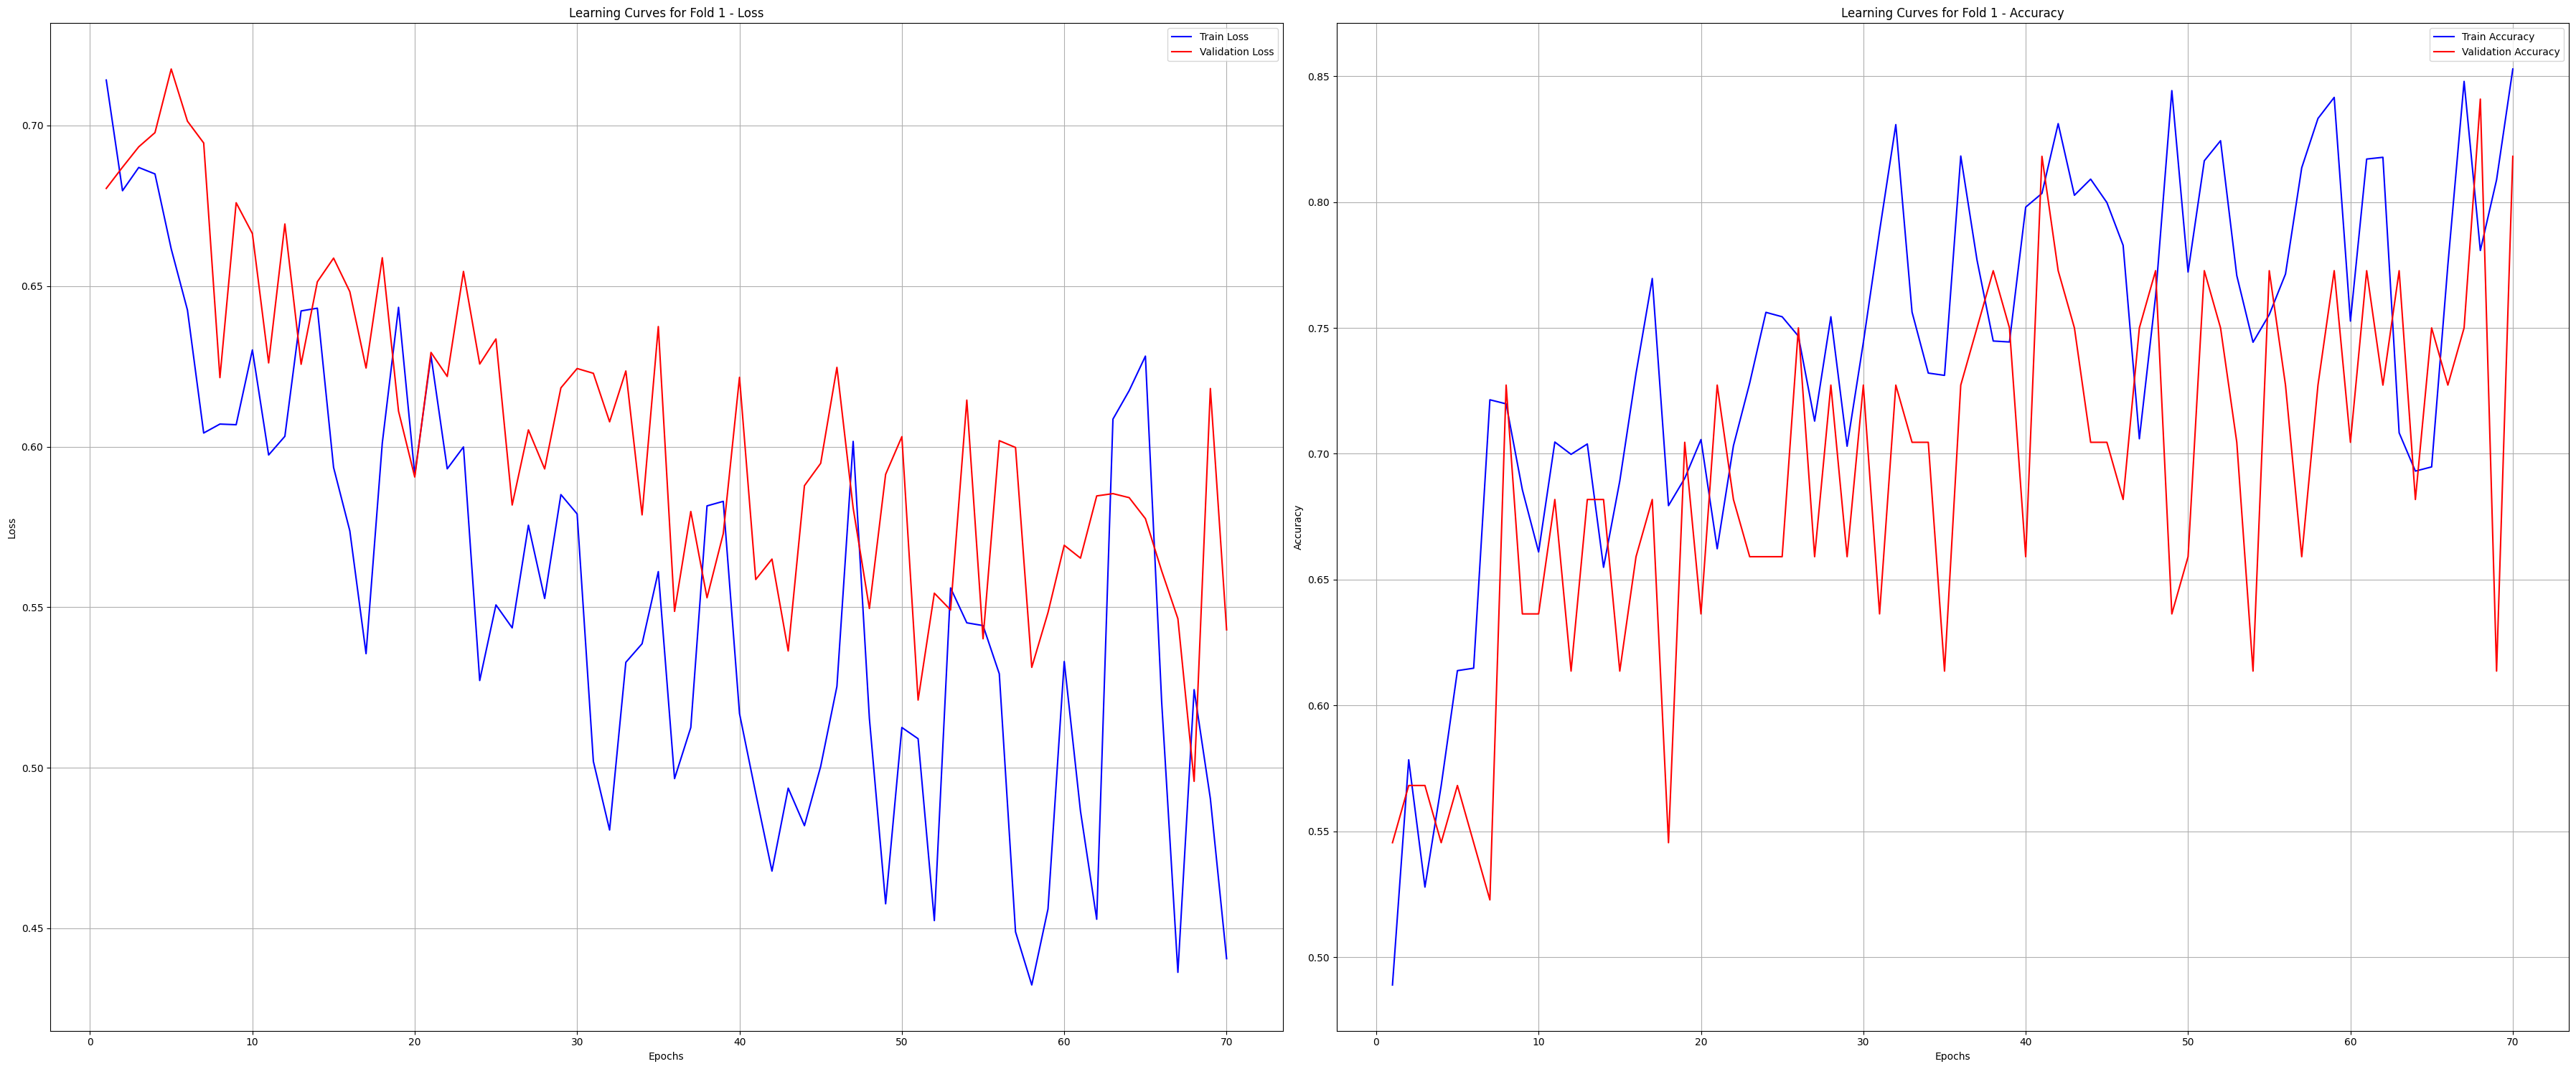

In [19]:
def plot_learning_curves(train_loss, val_loss, train_acc, val_acc, title="Learning Curves"):
    """
    Plot learning curves for loss and accuracy.

    Parameters:
        train_loss (list or tensor): Training loss values per epoch.
        val_loss (list or tensor): Validation loss values per epoch.
        train_acc (list or tensor): Training accuracy values per epoch.
        val_acc (list or tensor): Validation accuracy values per epoch.
        title (str): Title for the plots.
    """
    # Ensure data is on CPU and converted to numpy if they are tensors
    if isinstance(train_loss, torch.Tensor):
        train_loss = train_loss.detach().cpu().numpy()
    if isinstance(val_loss, torch.Tensor):
        val_loss = val_loss.detach().cpu().numpy()
    if isinstance(train_acc, torch.Tensor):
        train_acc = train_acc.detach().cpu().numpy()
    if isinstance(val_acc, torch.Tensor):
        val_acc = val_acc.detach().cpu().numpy()

    # Handle nested structures (lists of tensors)
    if isinstance(train_loss, list):
        train_loss = np.array([v.detach().cpu().numpy() if isinstance(v, torch.Tensor) else v for v in train_loss])
    if isinstance(val_loss, list):
        val_loss = np.array([v.detach().cpu().numpy() if isinstance(v, torch.Tensor) else v for v in val_loss])
    if isinstance(train_acc, list):
        train_acc = np.array([v.detach().cpu().numpy() if isinstance(v, torch.Tensor) else v for v in train_acc])
    if isinstance(val_acc, list):
        val_acc = np.array([v.detach().cpu().numpy() if isinstance(v, torch.Tensor) else v for v in val_acc])

    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(36, 15))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='', color='red')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='', color='blue')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='', color='red')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Example usage
fold_idx = 0  # Replace with the fold index you want to plot
train_loss = fold_metrics['train_loss'][fold_idx]
val_loss = fold_metrics['val_loss'][fold_idx]
train_acc = fold_metrics['train_acc'][fold_idx]
val_acc = fold_metrics['val_acc'][fold_idx]

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, title=f"Learning Curves for Fold {fold_idx + 1}")


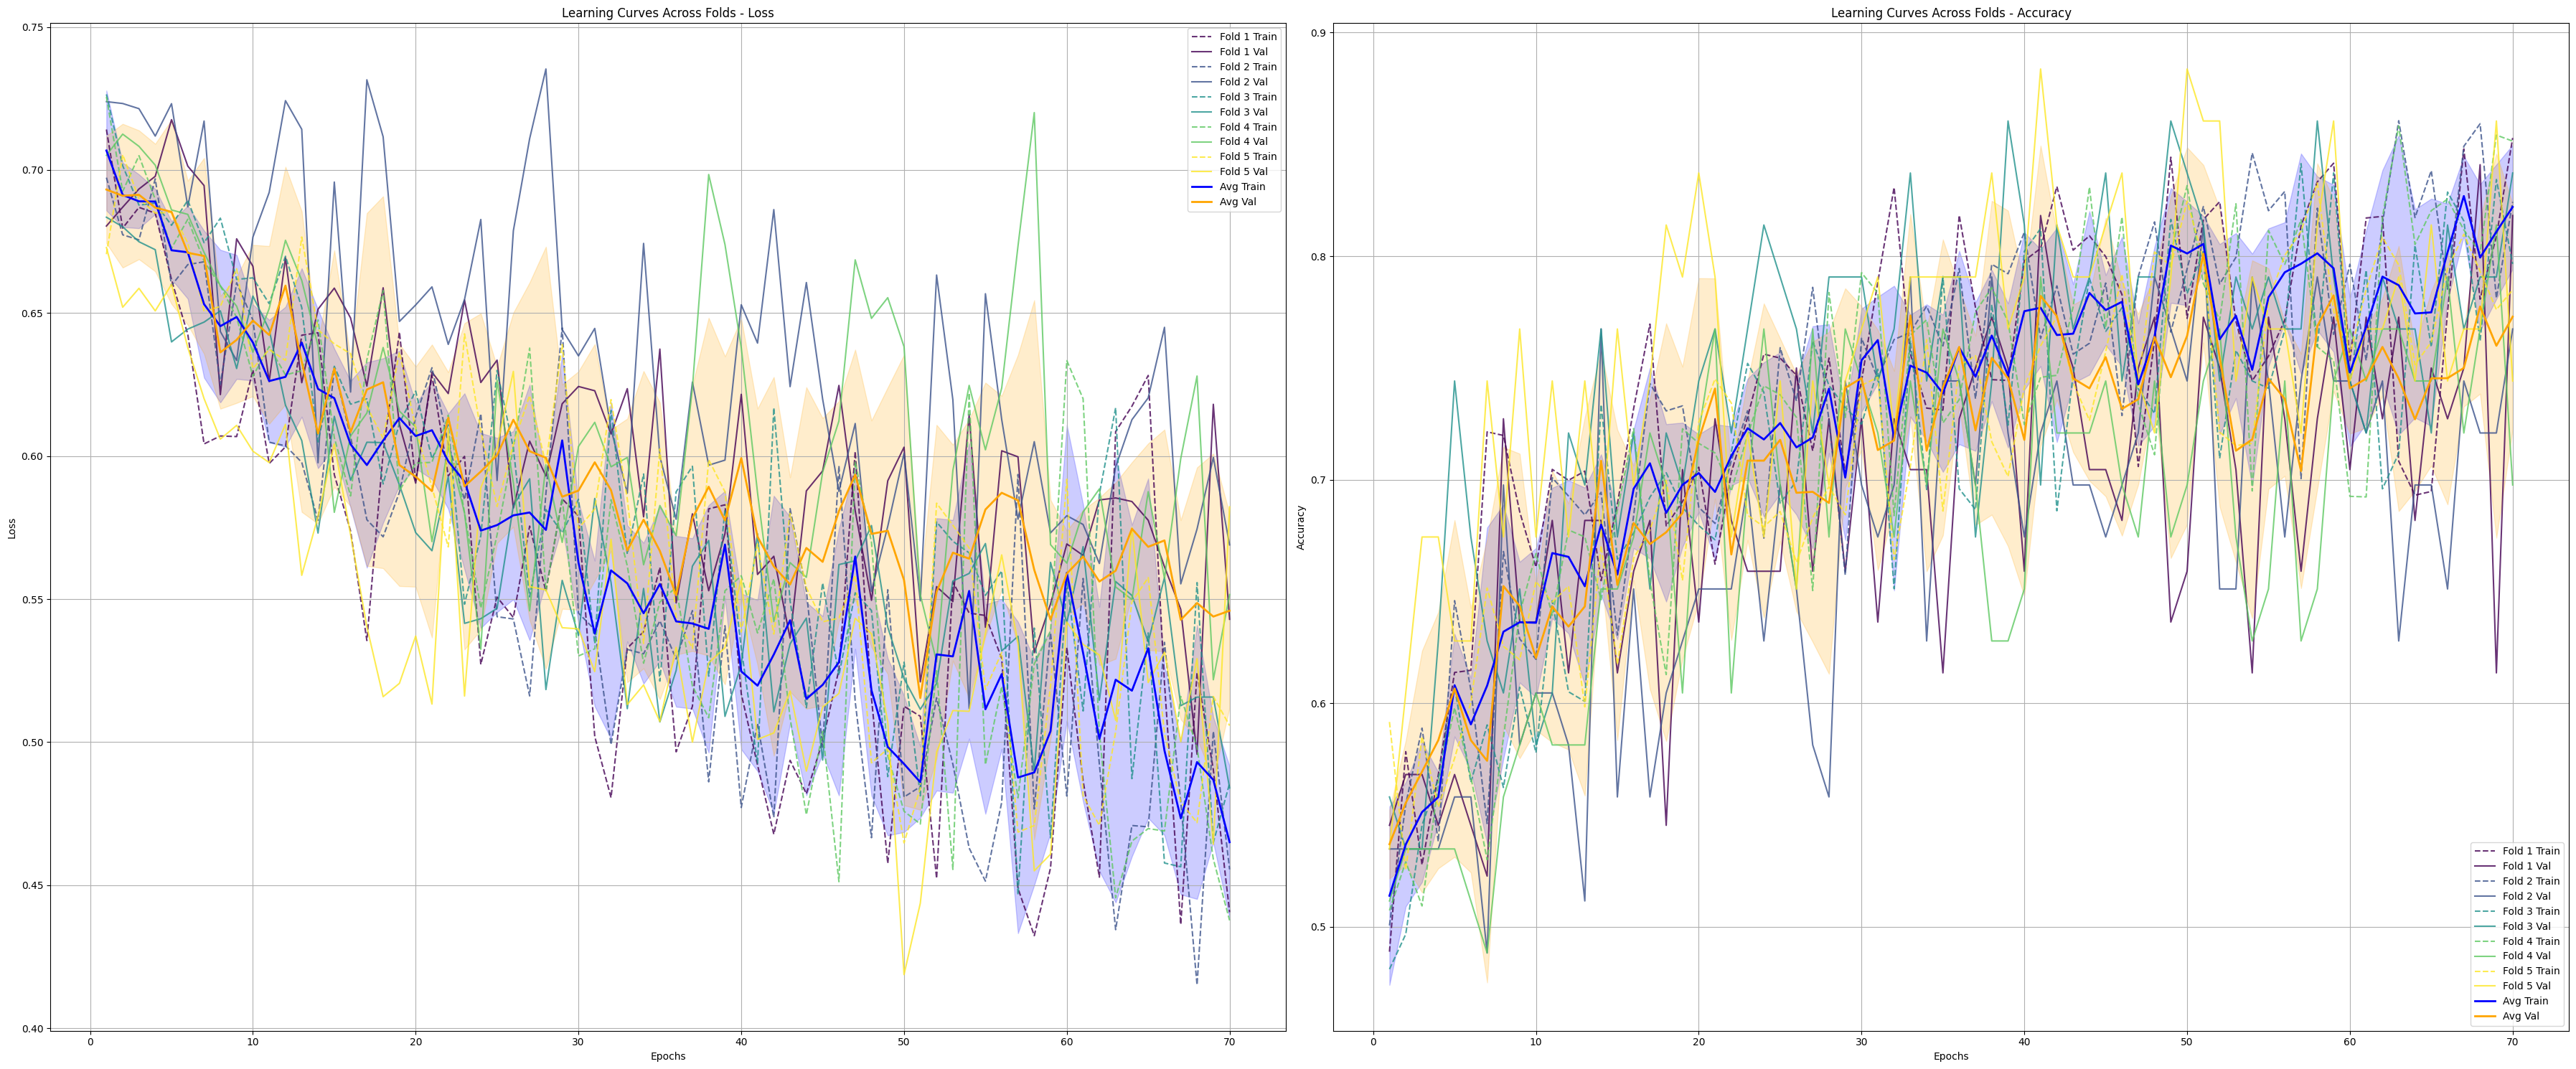

In [20]:
import matplotlib.cm as cm

def plot_all_and_average_learning_curves(fold_metrics, title="Learning Curves Across Folds"):
    """
    Plot all fold learning curves with different colors, along with the average curve.

    Parameters:
        fold_metrics (dict): Dictionary containing lists of metrics for each fold.
        title (str): Title for the plots.
    """
    def to_numpy(data):
        """Helper function to convert tensors to NumPy arrays."""
        if isinstance(data, torch.Tensor):
            return data.detach().cpu().numpy()
        if isinstance(data, list):
            return np.array([x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in data])
        return np.array(data)

    # Convert fold metrics to NumPy arrays
    train_loss = [to_numpy(f) for f in fold_metrics['train_loss']]
    val_loss = [to_numpy(f) for f in fold_metrics['val_loss']]
    train_acc = [to_numpy(f) for f in fold_metrics['train_acc']]
    val_acc = [to_numpy(f) for f in fold_metrics['val_acc']]

    # Compute the average and standard deviation for each epoch across folds
    avg_train_loss = np.mean(train_loss, axis=0)
    std_train_loss = np.std(train_loss, axis=0)

    avg_val_loss = np.mean(val_loss, axis=0)
    std_val_loss = np.std(val_loss, axis=0)

    avg_train_acc = np.mean(train_acc, axis=0)
    std_train_acc = np.std(train_acc, axis=0)

    avg_val_acc = np.mean(val_acc, axis=0)
    std_val_acc = np.std(val_acc, axis=0)

    epochs = range(1, len(avg_train_loss) + 1)

    # Generate colors for each fold
    num_folds = len(train_loss)
    colors = cm.viridis(np.linspace(0, 1, num_folds))  # Use colormap for fold colors

    # Plot Loss
    plt.figure(figsize=(36, 15))
    plt.subplot(1, 2, 1)
    for i, (fold_train_loss, fold_val_loss) in enumerate(zip(train_loss, val_loss)):
        plt.plot(epochs, fold_train_loss, label=f'Fold {i+1} Train', color=colors[i], linestyle='--', alpha=0.8)
        plt.plot(epochs, fold_val_loss, label=f'Fold {i+1} Val', color=colors[i], alpha=0.8)
    plt.plot(epochs, avg_train_loss, label='Avg Train', marker='', color='blue', linewidth=2)
    plt.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)
    plt.plot(epochs, avg_val_loss, label='Avg Val', marker='', color='orange', linewidth=2)
    plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for i, (fold_train_acc, fold_val_acc) in enumerate(zip(train_acc, val_acc)):
        plt.plot(epochs, fold_train_acc, label=f'Fold {i+1} Train', color=colors[i], linestyle='--', alpha=0.8)
        plt.plot(epochs, fold_val_acc, label=f'Fold {i+1} Val', color=colors[i], alpha=0.8)
    plt.plot(epochs, avg_train_acc, label='Avg Train', marker='', color='blue', linewidth=2)
    plt.fill_between(epochs, avg_train_acc - std_train_acc, avg_train_acc + std_train_acc, color='blue', alpha=0.2)
    plt.plot(epochs, avg_val_acc, label='Avg Val', marker='', color='orange', linewidth=2)
    plt.fill_between(epochs, avg_val_acc - std_val_acc, avg_val_acc + std_val_acc, color='orange', alpha=0.2)
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot all fold curves and averages
plot_all_and_average_learning_curves(fold_metrics, title="Learning Curves Across Folds")


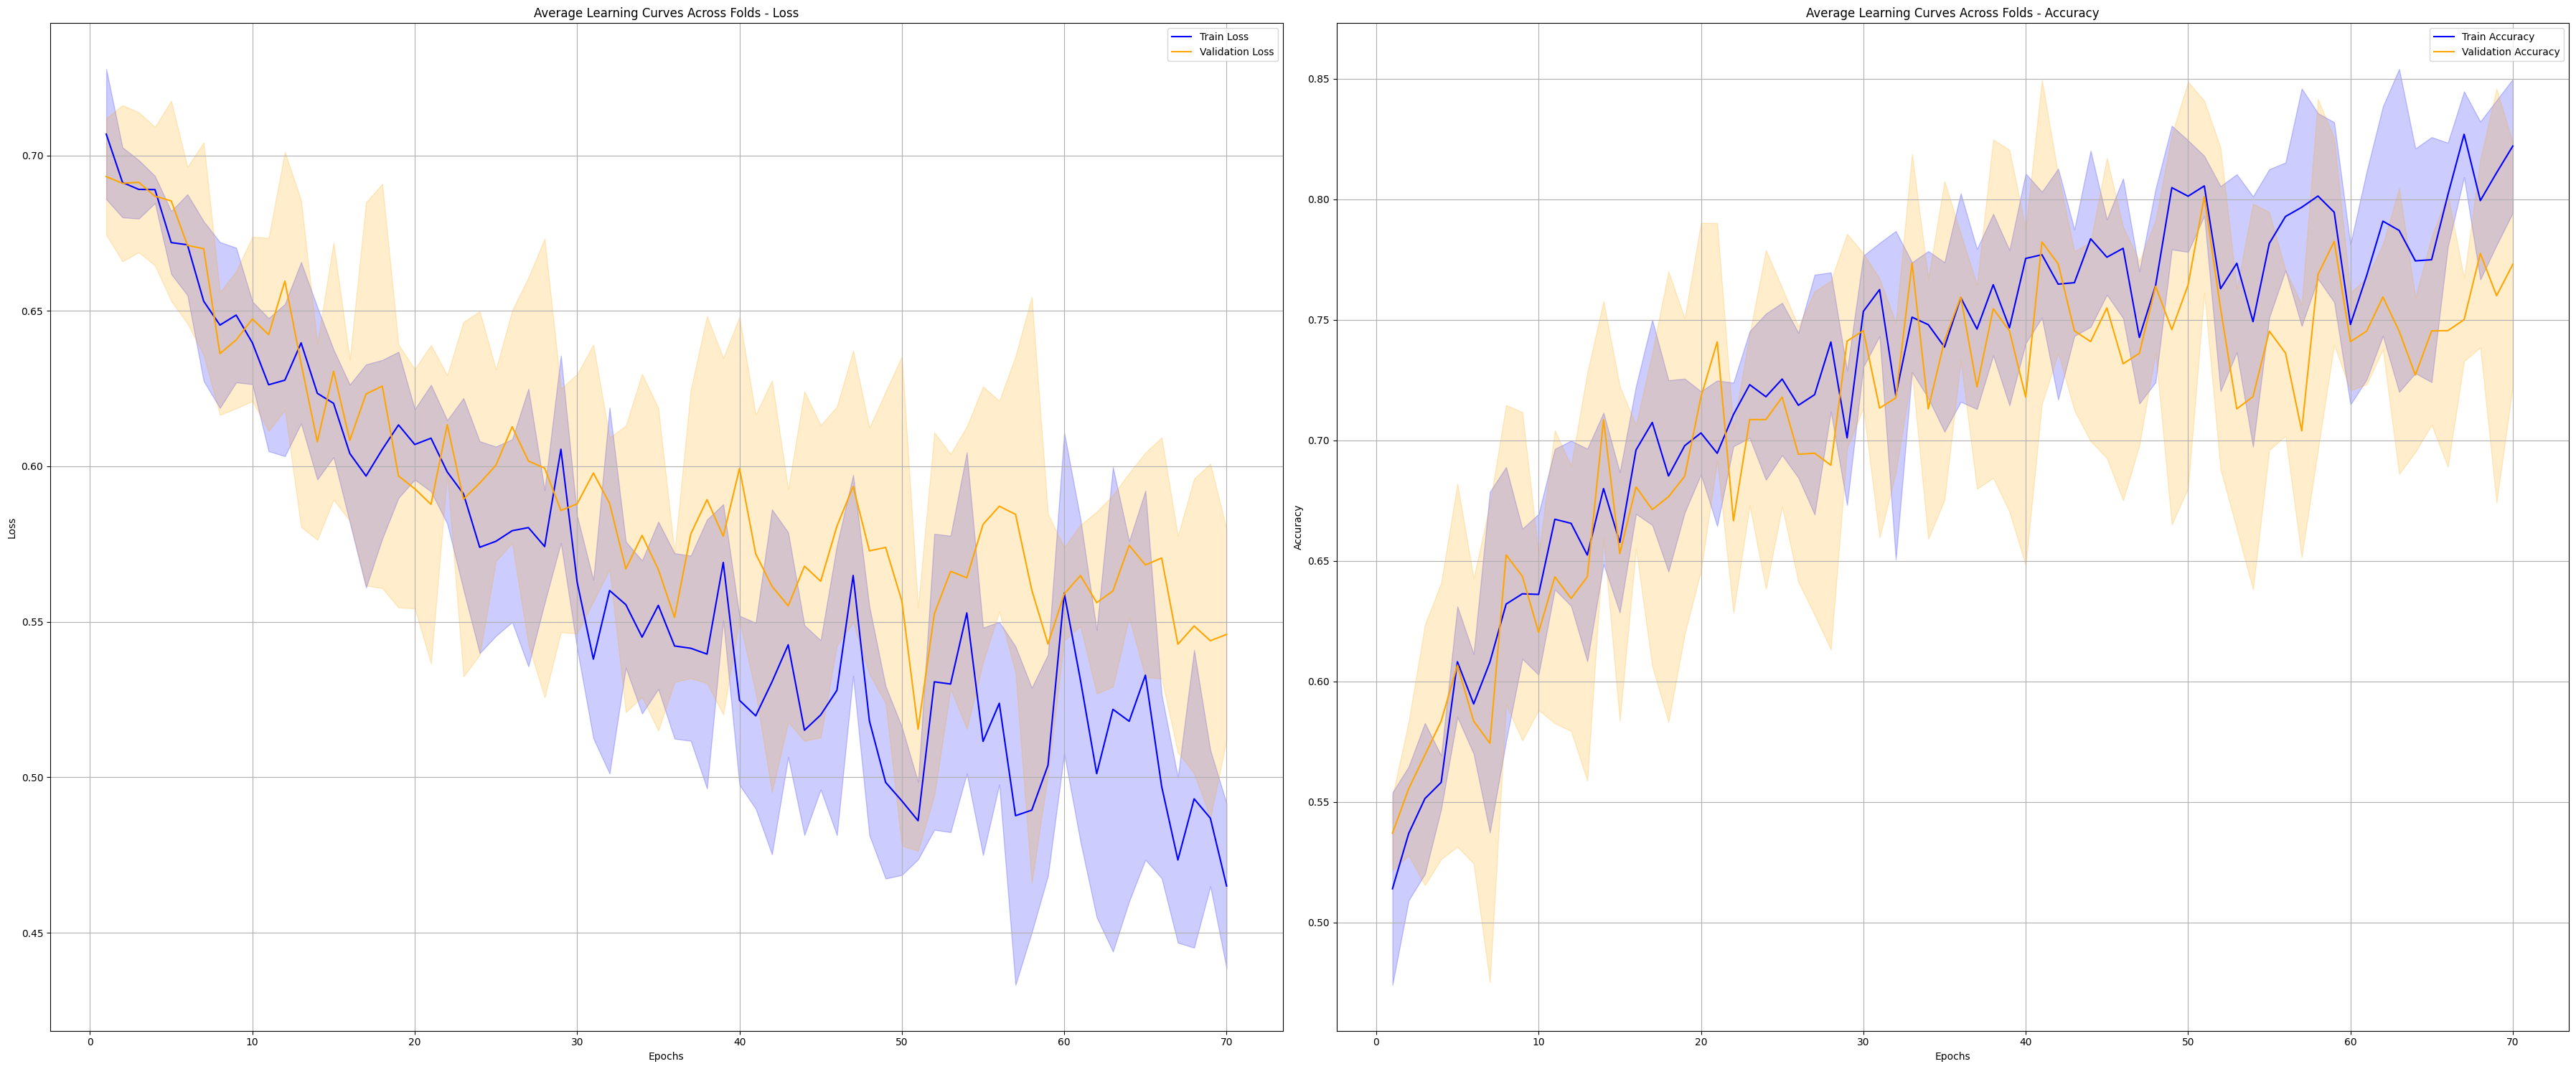

In [21]:
def plot_average_learning_curves(fold_metrics, title="Average Learning Curves"):
    """
    Plot average learning curves for loss and accuracy across k folds.

    Parameters:
        fold_metrics (dict): Dictionary containing lists of metrics for each fold.
        title (str): Title for the plots.
    """
    def to_numpy(data):
        """Helper function to convert tensors to NumPy arrays."""
        if isinstance(data, torch.Tensor):
            return data.detach().cpu().numpy()
        if isinstance(data, list):
            return np.array([x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in data])
        return np.array(data)

    # Convert fold metrics to NumPy arrays
    train_loss = [to_numpy(f) for f in fold_metrics['train_loss']]
    val_loss = [to_numpy(f) for f in fold_metrics['val_loss']]
    train_acc = [to_numpy(f) for f in fold_metrics['train_acc']]
    val_acc = [to_numpy(f) for f in fold_metrics['val_acc']]

    # Compute the average and standard deviation for each epoch across folds
    avg_train_loss = np.mean(train_loss, axis=0)
    std_train_loss = np.std(train_loss, axis=0)

    avg_val_loss = np.mean(val_loss, axis=0)
    std_val_loss = np.std(val_loss, axis=0)

    avg_train_acc = np.mean(train_acc, axis=0)
    std_train_acc = np.std(train_acc, axis=0)

    avg_val_acc = np.mean(val_acc, axis=0)
    std_val_acc = np.std(val_acc, axis=0)

    epochs = range(1, len(avg_train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(36, 15))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_train_loss, label='Train Loss', marker='', color='blue')
    plt.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)
    plt.plot(epochs, avg_val_loss, label='Validation Loss', marker='', color='orange')
    plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_train_acc, label='Train Accuracy', marker='', color='blue')
    plt.fill_between(epochs, avg_train_acc - std_train_acc, avg_train_acc + std_train_acc, color='blue', alpha=0.2)
    plt.plot(epochs, avg_val_acc, label='Validation Accuracy', marker='', color='orange')
    plt.fill_between(epochs, avg_val_acc - std_val_acc, avg_val_acc + std_val_acc, color='orange', alpha=0.2)
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot the average learning curves
plot_average_learning_curves(fold_metrics, title="Average Learning Curves Across Folds")


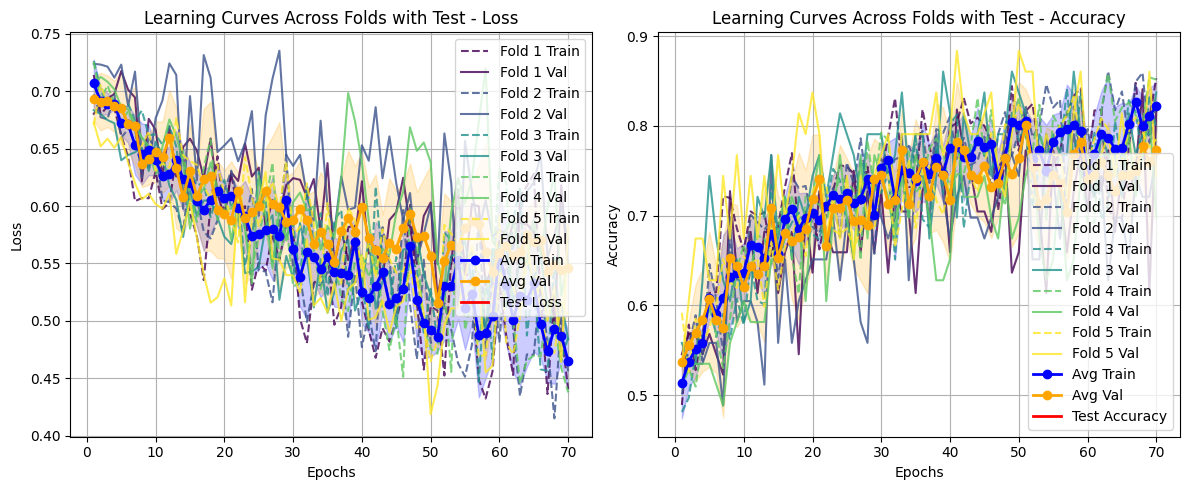

In [22]:
def plot_all_and_average_learning_curves_with_test(fold_metrics, title="Learning Curves Across Folds"):
    """
    Plot all fold learning curves with different colors, along with the average curve, and test results.

    Parameters:
        fold_metrics (dict): Dictionary containing lists of metrics for each fold, including test data.
        title (str): Title for the plots.
    """
    def to_numpy(data):
        """Helper function to convert tensors to NumPy arrays."""
        if isinstance(data, torch.Tensor):
            return data.detach().cpu().numpy()
        if isinstance(data, list):
            return np.array([x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in data])
        return np.array(data)

    # Convert fold metrics to NumPy arrays
    train_loss = [to_numpy(f) for f in fold_metrics['train_loss']]
    val_loss = [to_numpy(f) for f in fold_metrics['val_loss']]
    test_loss = [to_numpy(f) for f in fold_metrics['test_loss']]
    train_acc = [to_numpy(f) for f in fold_metrics['train_acc']]
    val_acc = [to_numpy(f) for f in fold_metrics['val_acc']]
    test_acc = [to_numpy(f) for f in fold_metrics['test_acc']]

    # Compute the average and standard deviation for each epoch across folds
    avg_train_loss = np.mean(train_loss, axis=0)
    std_train_loss = np.std(train_loss, axis=0)

    avg_val_loss = np.mean(val_loss, axis=0)
    std_val_loss = np.std(val_loss, axis=0)

    avg_test_loss = np.mean(test_loss, axis=0)
    avg_test_acc = np.mean(test_acc, axis=0)

    avg_train_acc = np.mean(train_acc, axis=0)
    std_train_acc = np.std(train_acc, axis=0)

    avg_val_acc = np.mean(val_acc, axis=0)
    std_val_acc = np.std(val_acc, axis=0)

    epochs = range(1, len(avg_train_loss) + 1)

    # Generate colors for each fold
    num_folds = len(train_loss)
    colors = cm.viridis(np.linspace(0, 1, num_folds))  # Use colormap for fold colors

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i, (fold_train_loss, fold_val_loss) in enumerate(zip(train_loss, val_loss)):
        plt.plot(epochs, fold_train_loss, label=f'Fold {i+1} Train', color=colors[i], linestyle='--', alpha=0.8)
        plt.plot(epochs, fold_val_loss, label=f'Fold {i+1} Val', color=colors[i], alpha=0.8)
    plt.plot(epochs, avg_train_loss, label='Avg Train', marker='o', color='blue', linewidth=2)
    plt.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)
    plt.plot(epochs, avg_val_loss, label='Avg Val', marker='o', color='orange', linewidth=2)
    plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)
    plt.axhline(avg_test_loss, label='Test Loss', color='red', linestyle='-', linewidth=2)
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for i, (fold_train_acc, fold_val_acc) in enumerate(zip(train_acc, val_acc)):
        plt.plot(epochs, fold_train_acc, label=f'Fold {i+1} Train', color=colors[i], linestyle='--', alpha=0.8)
        plt.plot(epochs, fold_val_acc, label=f'Fold {i+1} Val', color=colors[i], alpha=0.8)
    plt.plot(epochs, avg_train_acc, label='Avg Train', marker='o', color='blue', linewidth=2)
    plt.fill_between(epochs, avg_train_acc - std_train_acc, avg_train_acc + std_train_acc, color='blue', alpha=0.2)
    plt.plot(epochs, avg_val_acc, label='Avg Val', marker='o', color='orange', linewidth=2)
    plt.fill_between(epochs, avg_val_acc - std_val_acc, avg_val_acc + std_val_acc, color='orange', alpha=0.2)
    plt.axhline(avg_test_acc, label='Test Accuracy', color='red', linestyle='-', linewidth=2)
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot all fold curves and averages including test
plot_all_and_average_learning_curves_with_test(fold_metrics, title="Learning Curves Across Folds with Test")
